# Interventions in doWhy

In this notebook we investigate how to analyze interventions in the python package [doWhy](https://github.com/microsoft/dowhy).

Unlike a random controlled trial (RCT), the $do$ formalism by Pearl seeks to estimate the effect of an intervention: We do not want to compare the effect of two groups as we would in an RTC, e.g. $\delta = E[Y(X=1) - Y(X=0)]$ where one group receives a treatment ($X=1$) and the control group does not ($X=0$).

In the $do$-formalism, we want to estimate the effect directly if we apply an intervention $P(Y|do(X=x))$. Note that the intervention is not necessarily binary but can take any value.

The doWhy package allows to use the $do$ formalism on a stanard [Pandas](https://pandas.pydata.org) dataframe which is commonly used in data-science and AI applications. This signifiantly lowers the threshold to perform causal analyses.

In this example we use the built-in mechanism of the doWhy package to create a linear dataset according to a minimal causal model. In real appliations, we would use observational data and define a causal structure in form of a DAG ourselves.

N.B. This example follows some of the documentation of the doWhy package.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image, display
import graphviz as gv

import dowhy.api
from dowhy import CausalModel
import dowhy.datasets

## Create Dataset

We now create a dataset according to a minimal causal model that consists of a treatment (v0), an outcome (y) and a common cause (W0) that  affects both v0 and y.
The true causal effect we wish to measure is given by the parameter ```beta=5```, i.e. this is the quantity which we want to recover. Note that in reality this is unknown.

The method ```dowhy.datasets.linear_dataset``` creates a linear dataset according to the specified model, as well as the names of the variables (e.g. treatment, outcome, etc) and a string representation of the causal graph used to created the data.
The model also includes hidden confounders which we always have to consider present if we do not perfrom an random controlled trial.

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=10000,
        treatment_is_binary=True)

#print the full dictionary
print(data)

{'df':             W0     v0         y
0    -0.102119  False -0.132880
1     0.690987   True  5.894421
2    -0.156716   True  4.814261
3    -0.258650  False -0.331770
4     0.197426  False  0.236866
...        ...    ...       ...
9995  0.376492  False  0.490925
9996  0.700374  False  0.912737
9997 -1.722021  False -2.230543
9998 -0.607654  False -0.777811
9999 -0.142190  False -0.177631

[10000 rows x 3 columns], 'treatment_name': ['v0'], 'outcome_name': 'y', 'common_causes_names': ['W0'], 'instrument_names': [], 'effect_modifier_names': [], 'frontdoor_variables_names': [], 'dot_graph': 'digraph { U[label="Unobserved Confounders"]; U->y;v0->y;U->v0;W0-> v0;W0-> y;}', 'gml_graph': 'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"]node[ id "v0" label "v0"]edge[source "Unobserved Confounders" target "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"]

The object ```data``` contains a standard Pandas dataframe with the simulated observational data.
Here, we retrieve this dataframe and check that it is indeed "just" a Pandas dataframe by printing its type.

In [3]:
df = data["df"]
type(df)

pandas.core.frame.DataFrame

In [4]:
# retrieve the names of treatment, outcome and common causes
treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]

print('Treatment name: {}, outcome name: {}, name of common causes: {}'.format(treatment, outcome, common_cause))

# list the first few entries.
df.head(10)

Treatment name: v0, outcome name: y, name of common causes: W0


,W0,v0,y
0,-0.102119,False,-0.132880
1,0.690987,True,5.894421
2,-0.156716,True,4.814261
3,-0.258650,False,-0.331770
4,0.197426,False,0.236866
5,0.437805,False,0.567671
6,-0.585141,False,-0.763559
7,-0.695937,False,-0.911531
8,1.271753,True,6.635740
9,0.967264,True,6.247690


We can visualize the model that has been used to create the data with. The function also returns a special string in the 'dot-graph' format that shows the DAG that corresponds to the causal model.

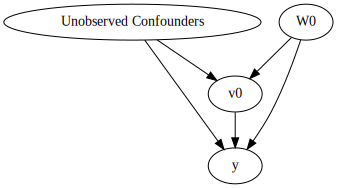

In [5]:
gv.Source(data["dot_graph"])

## Perform Causal Analysis

Now we use the functionality of the doWhy package to apply the $do$ operator.
In our case, the treatment is binary,i.e. we can apply the treatment or not.
We work with the standard Pandas dataframe ```df```. In this example we have obtained this from the helper function generating the data, in general this would contain our observational data.

Since the implementation of the $do$ operator does not know the structure of the variables and the DAG, we have to specify this when applying the function.

In particular we have to specify:
* the variable types for each variable in the dataframe. In our case we have the variables ```treatment```, ```outcome``` and ```common_cause``` and we have to tell the package the type of teh variables. The following convention is used: ```b```: binary, ```d```: discrete, ```o```: ordered discrete, ```u```: unordered discrete, ```c```: continuous.
* which variable corresponds to the treatment ```x```
* which variable corresponds to the outcome
* which variables correspond to the common causes for treatment and outcome
* the causal graph we assume in the 'dot-graph' format

Remeber that there may always be confounders that we have not considered in our DAG when working with observational data, so we tell the method explicitly that we have understood this and ignore the warning via ```proceed_when_unidentifiable=True```

Since our treatment is binary, we have only two possible actions: apply the treatment or not. This corresponds to $do(X=1)$ and $do(X=0)$. In other scenarios we may have multiple actions or the actions may be continuous, for example, if we vary the dose of a medicine.

To apply the $do$ operator, we provide the treatment variable ```x``` with a dictionary that specifies that the variable ```treatment``` in the DAG is set to either 0 or 1.
Each action results in a new dataframe, corresponding to $P(Y|do(X=1)$ and 
$P(Y|do(X=0)$.

For each call of the $do$ operator, the method creates a random sample
corresponding to $P(Y|do(X=\{0,1\})$, meaning that repeated executions of the same function result in different values in the dataframe.

In [6]:
df_doX_1 = df.causal.do(x={treatment: 1},
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     dot_graph=data['dot_graph'],
                     proceed_when_unidentifiable=True)

df_doX_0 = df.causal.do(x={treatment: 0},
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     dot_graph=data['dot_graph'],
                     proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume 

Now we look at the resulting dataframes, first for $do(X=0)$

In [7]:
df_doX_0.head()


,W0,v0,y,propensity_score,weight
0,1.651710,False,2.138547,0.034011,29.402093
1,-0.901139,False,-1.164213,0.871448,1.147515
2,1.052419,False,1.355390,0.107975,9.261365
3,0.071329,False,0.109980,0.477515,2.094173
4,0.311884,False,0.402176,0.357628,2.796205


Note that behind the scenes the propensity score is calcualted and the samples
weighted appropriately to be able to apply the $do$ operator.

Then we look at the result for $do(X=1)$:

In [8]:
df_doX_1.head()

,W0,v0,y,propensity_score,weight
0,0.910949,True,6.177455,0.860576,1.162012
1,1.798837,True,7.316060,0.974658,1.026001
2,-0.536044,True,4.311816,0.238390,4.194808
3,0.403481,True,5.523008,0.684476,1.460972
4,-0.051614,True,4.929209,0.459258,2.177426


Finally, we compute the average treatment effect (ATE). This is the variable we would compute in a random controlled trial (RCT) where we compare the treatment with the control group. 

Remember that in a RCT we cannot observe the outcome in the cases where we both apply the treatment to an individual or not apply the treatment. Hence in an RCT we assign indiviuals randomly to the treatment and control group.

However, within the $do$framework, we can make this observation by using the $do$-calculus to determine the outcome for $P(Y|do(X=0))$ and $P(Y|do(X=1))$.
Therefore, to calculate the ATE, we need to take the average of
the individual results - something we cannot do in an RCT.

Note that this is the quantity we wish to recover when we generated the dataset with the helper function in the beginning and the numerical value was controlled by the variable ```beta```, i.e. the value computed below should correspond to the value of ```beta``` earlier.

As we can see from the result, we have recovered the causal effect quite well.

In [9]:
#estimate causal effect
ATE_do = (df_doX_1['y'] - df_doX_0['y']).mean()
print('Causal effect (ATE): {}'.format(ATE_do))

Causal effect (ATE): 5.02725334532164


## Compare to Random Controlled Trial

Compare to the case where we mimic a RCT by propensity score weighting
Note that in this case we only get the results for the causal effect but not the causal dataframe.


In [10]:
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                     
─────(Expectation(y|W0))
d[v₀]                   
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [11]:
ATE_RCT = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(ATE_RCT)
print("Causal Estimate is " + str(ATE_RCT.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0
Target units: ate

## Estimate
Mean value: 5.0026513650015065

Causal Estimate is 5.0026513650015065


/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/kerzel/VirtualEnvs/CausalityEnv/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


As we can see we can also recover the original causal effect.